<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
import time

from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('/datasets/taxi.csv') # /datasets/
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные прочитали, пропусков нет.

Сделаем столбец `datetime` индексом.

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df['datetime'])
df = df.drop(['datetime'], axis=1)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Ресемплируем данные по одному часу.

In [4]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим индекс на монотонность.

In [5]:
df.index.is_monotonic

True

**Вывод:**  
Данные прочитали и подготовили к анализу.  

## Анализ

Данные это временной ряд. Есть только индекс - дата/время и цель.  

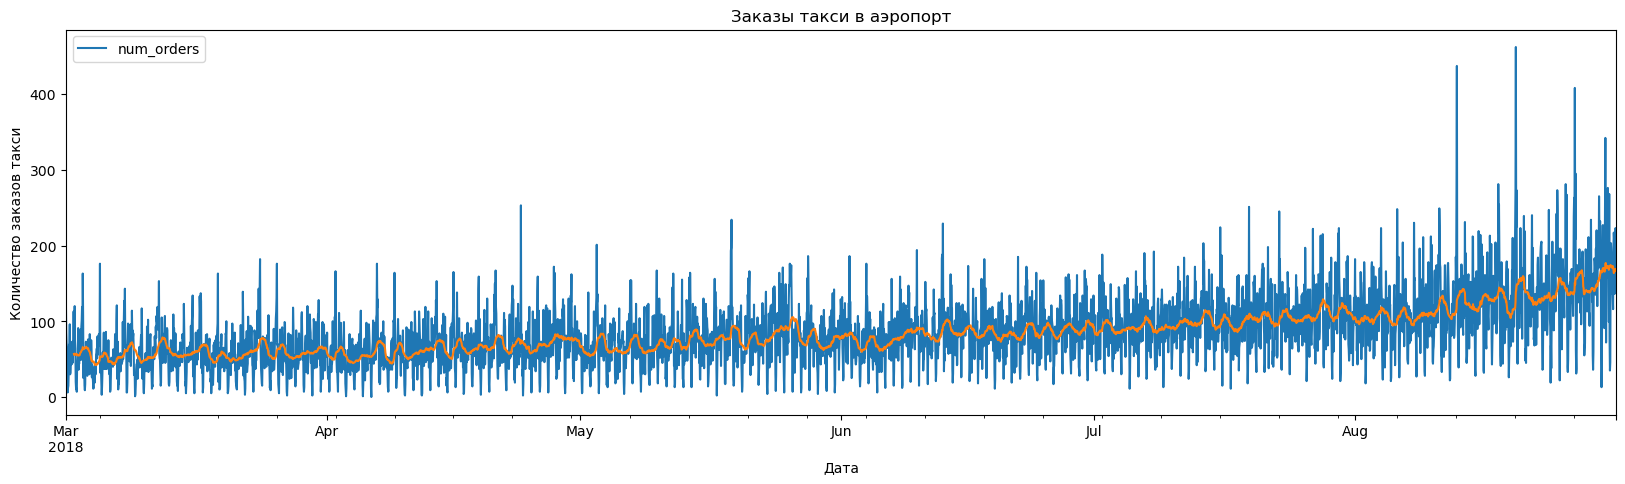

In [6]:
plt.figure(figsize=(20, 5))
df.plot(ax=plt.gca())
df['num_orders'].rolling(24).mean().plot()
plt.title('Заказы такси в аэропорт')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси');

Из графика временного ряда и скользящего среднего видим, что график постепенно растет, при этом имеет явные локальные минимумы и максимумы.    
Проанализируем отдельные компоненты: тренд, сезонность и шум.  

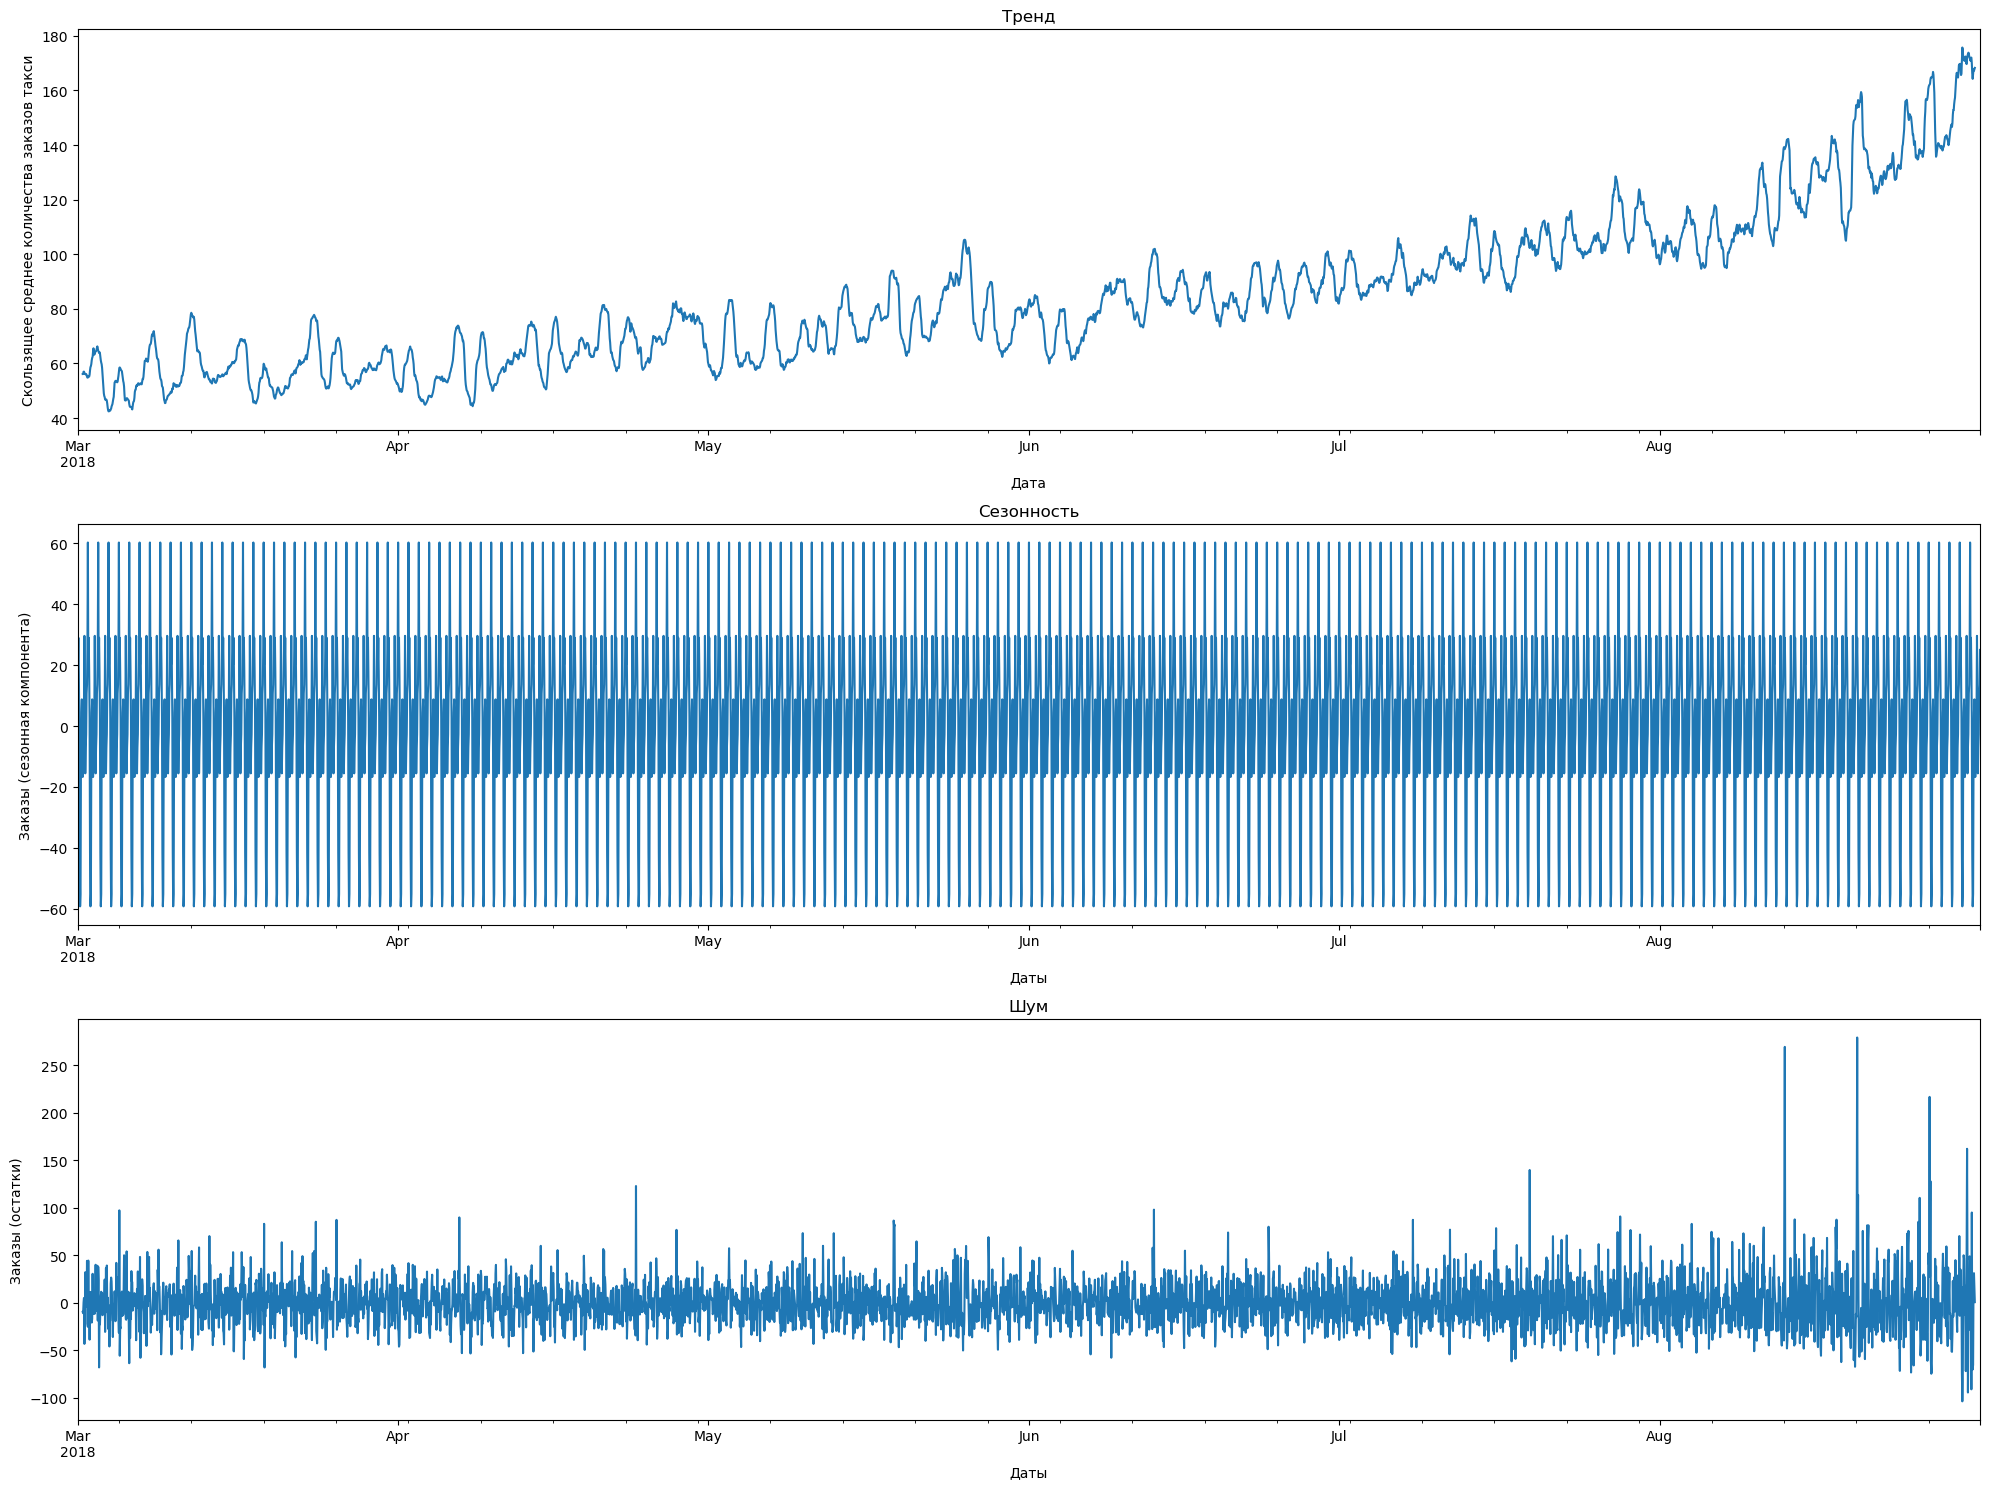

In [7]:
d = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(20, 15))

plt.subplot(311)
d.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Скользящее среднее количества заказов такси')
plt.subplot(312)
d.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Даты')
plt.ylabel('Заказы (сезонная компонента)')
plt.subplot(313)
d.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.xlabel('Даты')
plt.ylabel('Заказы (остатки)')
plt.tight_layout()

Из графика тренда видим выраженный восходящий тренд по всему временному ряду.  
График сезонности имеет периодические колебания, возможно связанные с рейсами из аэропорта, нужно рассмотреть в меньшем масштабе.
График шума в основном стационарен. В конце графика присутствуют какие-то колебания, необходимо провести тест Дики-Фуллера.

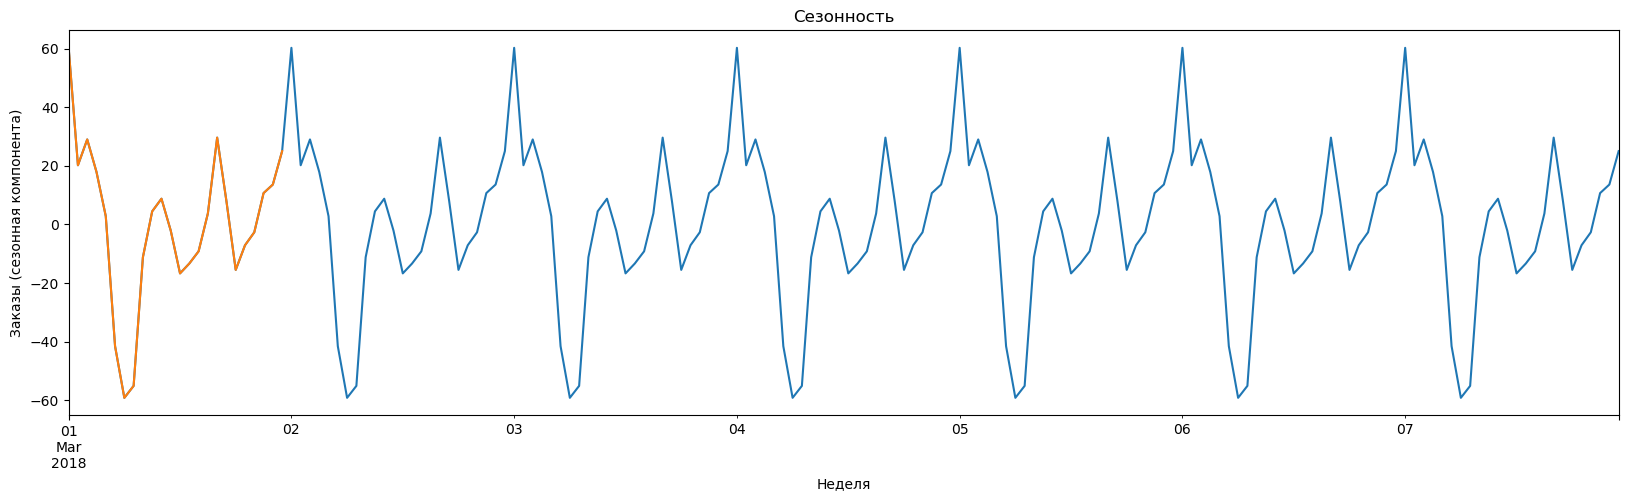

In [8]:
#d = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(20, 5))
d.seasonal.iloc[:168].plot(ax=plt.gca())
d.seasonal.iloc[:24].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Неделя')
plt.ylabel('Заказы (сезонная компонента)');

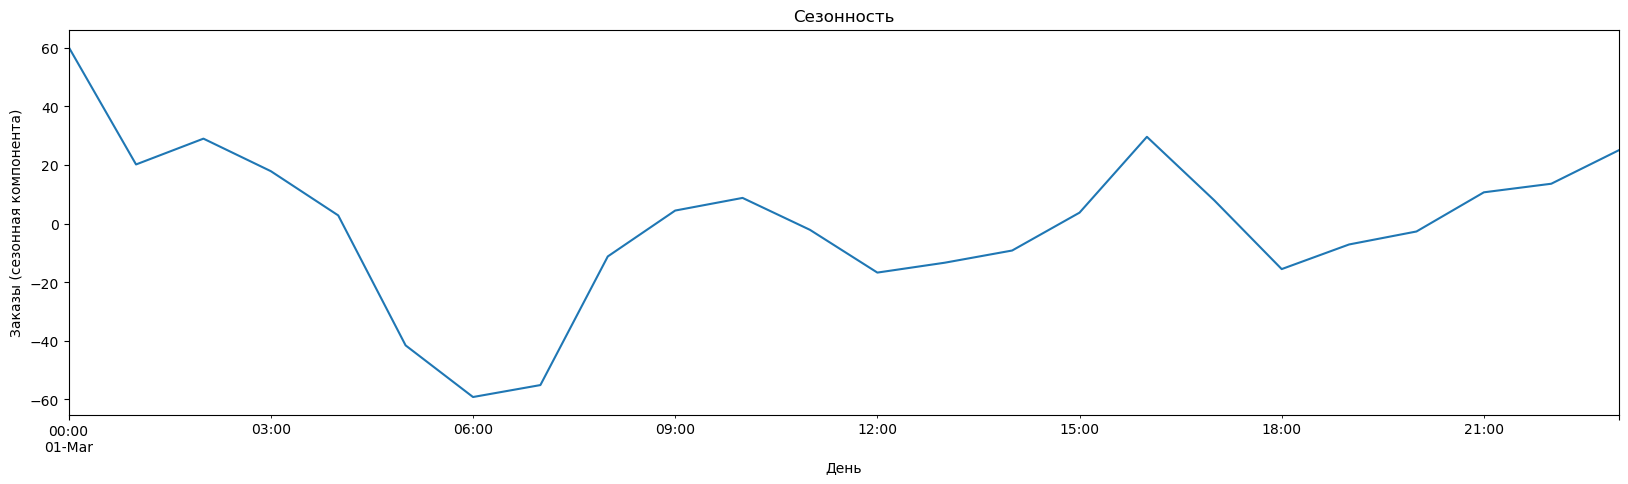

In [9]:
plt.figure(figsize=(20, 5))
d.seasonal.iloc[:24].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('День')
plt.ylabel('Заказы (сезонная компонента)');

На графиках сезонности за неделю видим одинаковые колебания каждый день, очевидно связанные с расписанием рейсов.  
На графике за один день видно, что основное количество прилетов/вылетов начинается с 6 утра постепенно увеличиваясь до 12 ночи, потом активность начинает спадать до 6 утра следующего дня.    
График сезонности показывет выраженную суточную периодичность, связанную с графиком и количеством рейсов самолетов.  

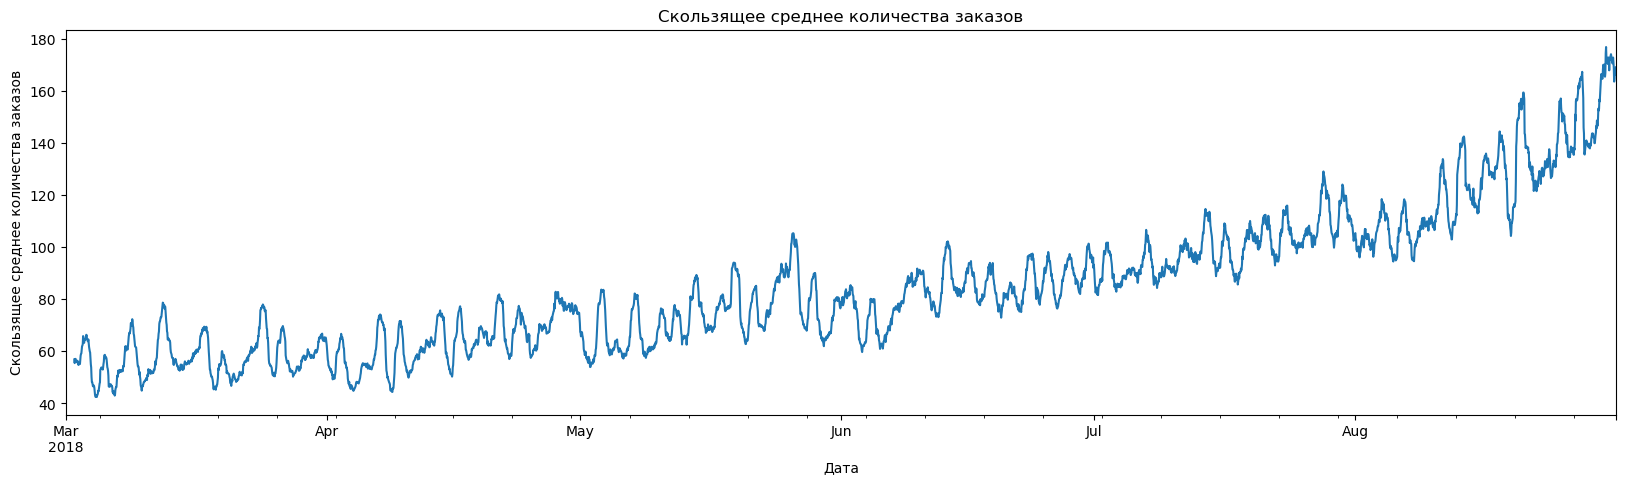

In [10]:
plt.figure(figsize=(20, 5))
df['num_orders'].shift().rolling(24).mean().plot()
plt.title('Скользящее среднее количества заказов')
plt.xlabel('Дата')
plt.ylabel('Скользящее среднее количества заказов');

Скользящее среднее показывает очевидный тренд увеличения количества заказов такси со времением.  
Рассмотрим на меньшем масштабе, например за месяц.  

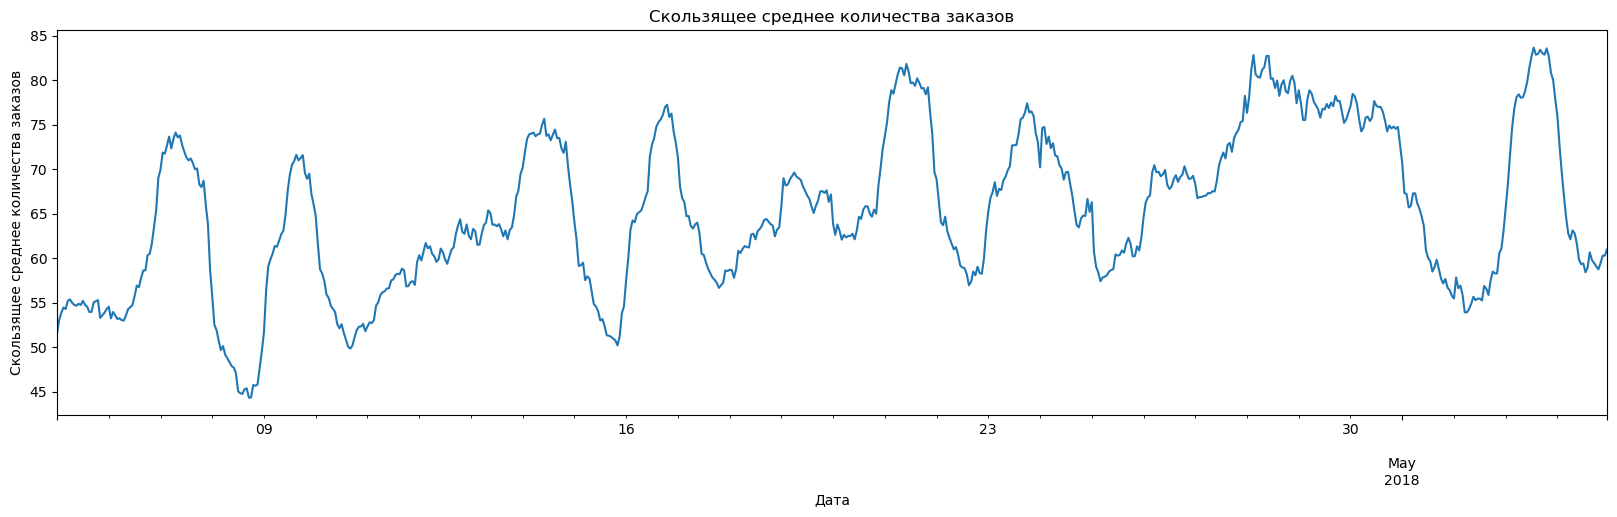

In [11]:
plt.figure(figsize=(20, 5))
df['num_orders'].shift().rolling(24).mean().iloc[840:1560].plot()
plt.title('Скользящее среднее количества заказов')
plt.xlabel('Дата')
plt.ylabel('Скользящее среднее количества заказов');

График демонстрирует явные минимумы и максимумы. Минимумы приходятся на понедельник, максимумы приходятся на вторник и выходные, при чем в выходные максимумы выше. Очевидно это связано с тем, что в выходные прилетает/улетает большее количество людей (отпуска), а во вторник начинают летать по работе.

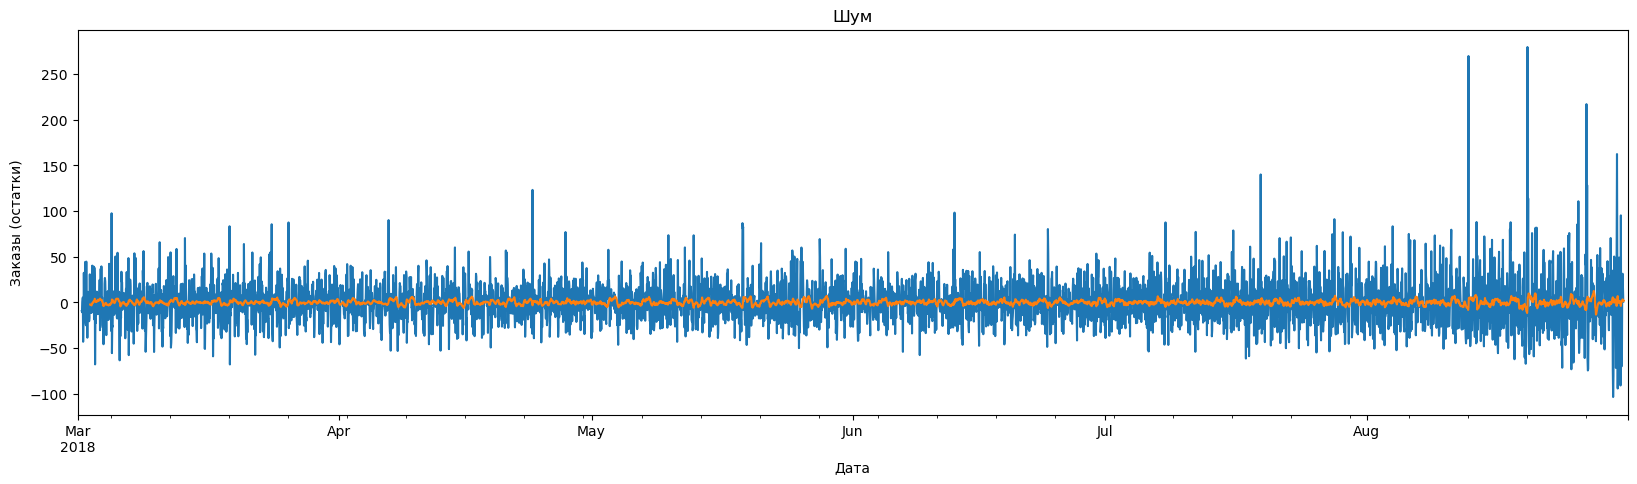

In [12]:
plt.figure(figsize=(20, 5))
d.resid.plot(ax=plt.gca())
d.resid.shift().rolling(24).mean().plot(ax=plt.gca())
plt.title('Шум')
plt.xlabel('Дата')
plt.ylabel('Заказы (остатки)');

На графике видно, что сглаженное среднее на протяжении почти всего ряда не меняется, значит ряд стационарен. Но в конце графика, присутствуют колебания и сглаженного среднего и самих значений, значит ряд не стационарен.  
Не понятно, что что предположить, проверим с помощью теста Дики-Фуллера.

In [13]:
result = adfuller(df['num_orders'], autolag='AIC')
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
    print ("На уровне 5% нулевая гипотеза отвергнута – Временной ряд не стационарен")
else:
    print ("На уровне 5% нулевая гипотеза не отвергнута – Временной ряд стационарен")
if result[0] > result[4]["1%"]:
    print ("На уровне 1% нулевая гипотеза отвергнута – Временной ряд не стационарен")
else:
    print ("На уровне 1% нулевая гипотеза не отвергнута – Временной ряд стационарен")       

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
На уровне 5% нулевая гипотеза не отвергнута – Временной ряд стационарен
На уровне 1% нулевая гипотеза отвергнута – Временной ряд не стационарен


Проверили гипотезу о стационарности ряда на уровнях значимости 1% и 5%. В первом случае ряд нестационарный, во втором - стационарный. С учётом динамики скользящего среднего принимаем решение о нестационарности ряда.

Тест Дики-Фуллера показал - ряд стационарен.

Добавим в данные признаки.  
Будем добавлять, час, день, день недели, тренд, скользящее среднее и 3 лага.  
Выбор количества лагов произвольный, скользящее среднее возьмем за день (24), сезонность добавить не можем, т.к. данные представлены только за 6 месяцев, по этой же причине не будем добавлять месяц.

Добавим признаки час, день, день недели.

In [14]:
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

Добавим признак тренда.

In [15]:
df['trend'] = seasonal_decompose(df['num_orders']).trend

Добавим признаки смещения.

In [16]:
for i in range(2, 26):
    df[f'lag_{i}'] = df['num_orders'].shift(i)

Добавим признак скользящего среднего.

In [17]:
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

Удалим пропуски

In [18]:
df = df.dropna()

In [19]:
df.head()

,num_orders,day,hour,dayofweek,trend,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,2,1,4,55.229167,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,55.416667
2018-03-02 02:00:00,75,2,2,4,55.416667,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,56.875000
2018-03-02 03:00:00,64,2,3,4,55.187500,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,57.041667
2018-03-02 04:00:00,20,2,4,4,55.854167,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,56.958333
2018-03-02 05:00:00,11,2,5,4,57.479167,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.000000


**Вывод:**  
Добавили в данные 8 признаков. 

**Вывод:**  
Получили данные - временной ряд.   
Проверили  - ряд монотонный без пропусков.  
Добавили 52 признака. Час, день, день недели, тренд, 24 лага, 24 скользящих средних.  
Можно обучать модели

## Обучение

Разделим данные на выборки.

In [20]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [22]:
def print_rmse_cross(model):
    print(f'RMSE на кросс-валидации: {(-(cross_val_score(model, features_train, target_train, cv=TimeSeriesSplit(), scoring="neg_mean_squared_error")).mean())**0.5:.1f}')
    

def print_rmse(model):
    print(f"RMSE на тестовой выборке: {mean_squared_error(target_test, model.predict(features_test))**0.5:.1f}")

Будем обучать 3 модели:
- Линейную регрессию
- Случайный лес
- lightGBM  

Лучшую выберем с помощью кросс-валидации.

### Линейная регрессия

In [23]:
model_lr = LinearRegression(n_jobs=-1)#.fit(features_train, target_train)

In [24]:
print_rmse_cross(model_lr)

RMSE на кросс-валидации: 25.3


### Случайный лес

In [25]:
model_rf = RandomForestRegressor(n_jobs=-1, random_state=68756)

In [26]:
param = {'grid':{ 'n_estimators': [20, 24],
                  'max_depth': [9, 12, 14, 16],
                  'min_samples_leaf': [4, 6, 7, 9],
                  'min_samples_split': range (3,8),
                  'max_features': range (4, 7),
                  
                },
         'rand':{ 
                  'max_features': range (2, 7),
                  'min_samples_split': range (2,11),
                  'min_samples_leaf': range (2,16),
                  'max_depth': range (2, 21),
                  'n_estimators': range(20, 30)           
                }
        }

Параметры подбирались 4 минуты.

In [27]:
start = time.time()
search = GridSearchCV(model_rf, param['grid'], cv=TimeSeriesSplit(), scoring = 'neg_mean_squared_error', n_jobs=-1)
search.fit(features_train, target_train)
print(f"Время подбора гиперпараметров GridSearchCV = {time.time() - start:.0f}с")

Время подбора гиперпараметров GridSearchCV = 49с


Лучшие параметры подобранные GridSearchCV:

In [28]:
search.best_params_

{'max_depth': 14,
 'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 24}

In [29]:
print(f'RMSE лучшей модели на кросс-валидации: {(-search.best_score_)**0.5:.1f}')

RMSE лучшей модели на кросс-валидации: 24.8


In [30]:
start = time.time()
search_RS = RandomizedSearchCV(model_rf, param['rand'], cv=TimeSeriesSplit(), scoring = 'neg_mean_squared_error', random_state=68756, n_jobs=-1)
search_RS.fit(features_train, target_train)
print(f"Время подбора гиперпараметров RandomizedSearchCV = {time.time() - start:.0f}с")

Время подбора гиперпараметров RandomizedSearchCV = 1с


Лучшие параметры подобранные RandomizedSearchCV:

In [31]:
search_RS.best_params_

{'n_estimators': 26,
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_features': 6,
 'max_depth': 13}

In [32]:
print(f'RMSE лучшей модели на кросс-валидации: {(-search.best_score_)**0.5:.1f}')

RMSE лучшей модели на кросс-валидации: 24.8


In [33]:
best_rf = search.best_estimator_
best_rf

RandomForestRegressor(max_depth=14, max_features=6, min_samples_leaf=4,
                      min_samples_split=3, n_estimators=24, n_jobs=-1,
                      random_state=68756)

Лучший подбор параметров показала модель GridSearchCV.  
Лучшая модель Случайного леса:   
RandomForestRegressor(max_depth=14, max_features=6, min_samples_leaf=4,
                      min_samples_split=3, n_estimators=24, n_jobs=-1,
                      random_state=68756)  

RMSE на кросс-валидации: 24.8

In [34]:
print(f'RMSE на кросс-валидации при оптимизации гиперпараметров у лучшей модели равна : {(-search_RS.best_score_)**0.5:.1f}')

RMSE на кросс-валидации при оптимизации гиперпараметров у лучшей модели равна : 25.3


### LightGBM

In [35]:
model_lgbm = LGBMRegressor(n_jobs=-1, random_state=68756)

In [36]:
param = {'n_estimators': range(20, 100)}

In [37]:
start = time.time()
search_LGBM = RandomizedSearchCV(model_lgbm, param, cv=TimeSeriesSplit(), scoring = 'neg_mean_squared_error', random_state=68756, n_jobs=-1)
search_LGBM.fit(features_train, target_train)
print(f"Время подбора гиперпараметров RandomizedSearchCV = {time.time() - start:.0f}с")

/Users/alexeigrib/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Время подбора гиперпараметров RandomizedSearchCV = 2с


In [38]:
print(f'RMSE лучшей модели на кросс-валидации: {(-search_LGBM.best_score_)**0.5:.1f}')

RMSE лучшей модели на кросс-валидации: 24.2


In [39]:
best_lgbm = search_LGBM.best_estimator_
best_lgbm

LGBMRegressor(n_estimators=89, random_state=68756)

Лучшая модель LightGBM - LGBMRegressor(n_estimators=89, random_state=68756)  

RMSE на кросс-валидации: 24.2

In [40]:
print(f'RMSE на кросс-валидации при оптимизации гиперпараметров у лучшей модели равна : {(-search_LGBM.best_score_)**0.5:.1f}')

RMSE на кросс-валидации при оптимизации гиперпараметров у лучшей модели равна : 24.2


**Вывод:**  
Обучили 3 модели. Лучший результат показала модель LightGBM. Будем тестировать ее.

## Тестирование

In [41]:
print_rmse(best_lgbm)

RMSE на тестовой выборке: 39.1


Модель, показавшая лучшие результаты на этапе обучения, на тестовой выборке показала RMSE = 39.1

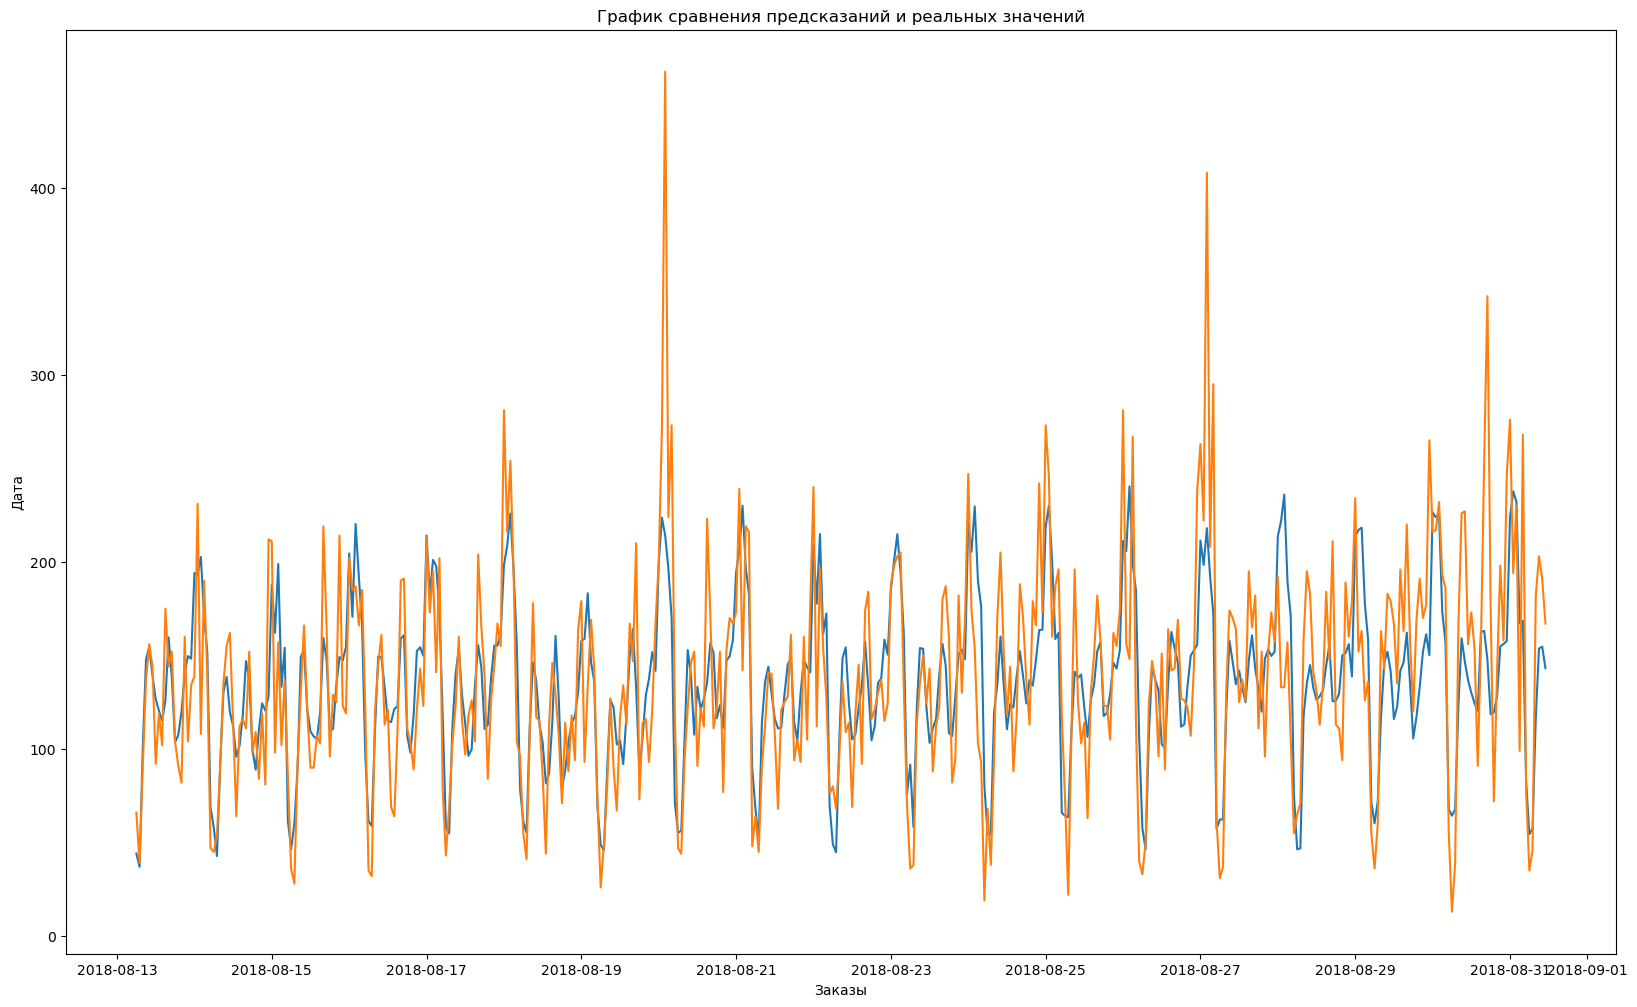

In [42]:
plt.figure(figsize=(20, 12))
plt.plot(pd.DataFrame(best_lgbm.predict(features_test), index=features_test.index))
plt.plot(pd.DataFrame(target_test, index=features_test.index))
plt.title('График сравнения предсказаний и реальных значений')
plt.xlabel('Заказы')
plt.ylabel('Дата');

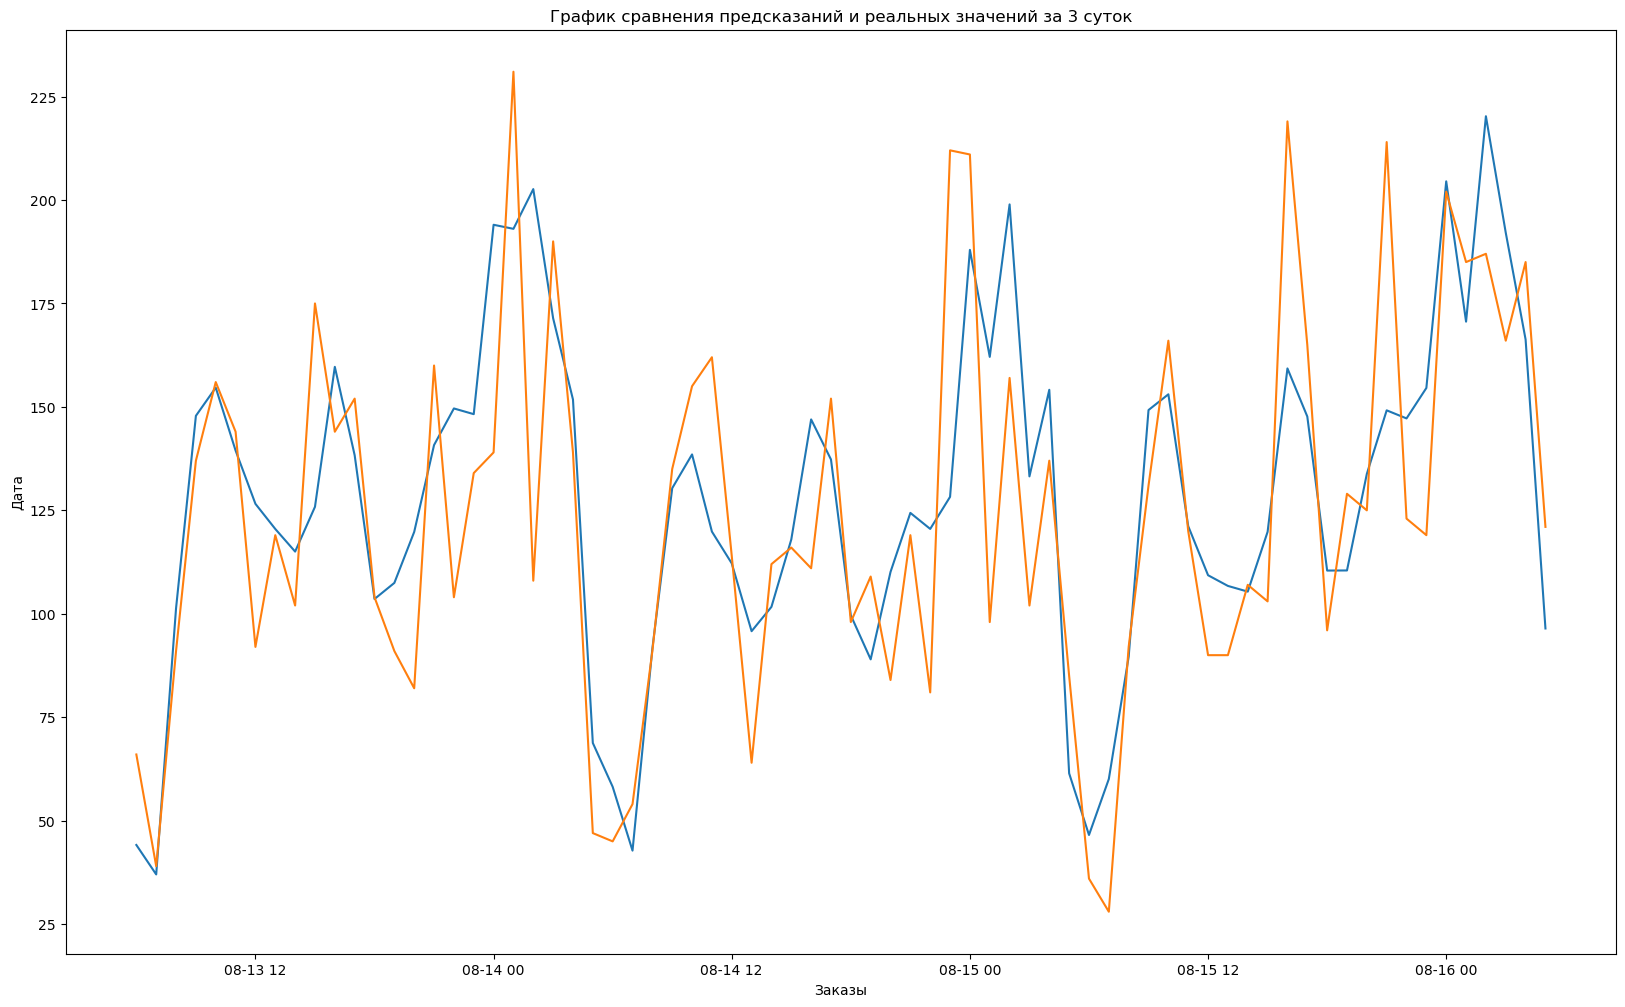

In [43]:
plt.figure(figsize=(20, 12))
plt.title('График сравнения предсказаний и реальных значений за 3 суток')
plt.xlabel('Заказы')
plt.ylabel('Дата');
plt.plot(pd.DataFrame(best_lgbm.predict(features_test), index=features_test.index).iloc[:72])
plt.plot(pd.DataFrame(target_test, index=features_test.index).iloc[:72]);

В целом по графикам видно, что модель плохо прогноризует пиковую нагрузку. Она преуменьшает потребность в пиковые моменты, среднюю потребность прогнозирует удовлетворительно.

In [44]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
print_rmse(dummy_regr)

RMSE на тестовой выборке: 83.7


Константная модель показала на тестовой выборке значение RMSE = 83.7  
Это в 2 раза больше, чем наша лучшая модель.  
Модель прошла проверку на адекватность.

**Вывод:**  
В процессе выполнения проекта мы
- Получили временной ряд
- Ресемплировали его
- Изменили индекс
- Добавили 29 признаков, подходящих по смыслу задачи. 
    - Причем скользящее среднее взяли с окном 24 (сутки), лагов добавили тоже 24 (сутки). Это значительно (с 40.6 до 39.1) улучшило метрику.
- Обучили 3 модели
- Подобрали для моделей гиперпараметры

Лучший результат показала модель LightGBM.  
Результат на тестовой выборке RMSE = 39.1